# Including 
* Single-Particle Theta and Real Space Hopping Phases
* Essential First Band Approximation Functions

In [2]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Theta Space.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Initial Parameters

In [95]:
# Lattice Size
Nx=3; Ny=3; N=Nx*Ny

# Magnetic Flux Per Plaquet
p=1; q=Ny; alpha=p/q

# Total Particle Number
PN=[0,1,2]

# Cut-Off for Sub-Space (Real Space for now...)
cut_off=9

# Interaction Potential
U = 2

# Theta Parameter Space
T_size=5;

# Single Particle Operator

In [96]:
function Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty)
        
    H_T = HSP_T(Nx, Ny, alpha, Tx, Ty, 0)
    
    H = SparseOperator(sp_basis)
    
    for m in 1:N
        for n in 1:N
            H = H + H_T[m,n] * transition(sp_basis, m, n)
        end
    end
    
    return H
end

Sp_Theta_Op (generic function with 1 method)

In [97]:
using LinearAlgebra

# Reference Parameters
Tx = Ty = 0
sp_basis = NLevelBasis(N)
eigenenergies(dense(Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty))) == eigvals(HSP_T(Nx, Ny, p/q, Tx, Ty, 0))
eigvals(HSP_T(Nx, Ny, p/q, Tx, Ty, 0))

9-element Vector{Float64}:
 -2.7320508075688794
 -2.7320508075688776
 -2.7320508075688767
  0.7320508075688769
  0.7320508075688776
  0.732050807568878
  1.9999999999999998
  2.0
  2.000000000000001

# Sub-Space Many-Body

In [98]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [99]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN);

In [100]:
function get_total_H(Nx, Ny, alpha, sp_basis, Tx, Ty, cut_off, PN, basis_cut_sp, basis_cut_mb)
    # Single Particle Operator
    H1 = Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty)
    
    # Sub-States Go on to Cut-Off
    sub_states = get_sub_states(H1, cut_off)

    # Sub-Space Basis and Projection Operator
    basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)

    # Single-Particle Sub-Space Operator
    H1_sub = get_subspace_op(H1, P, Pt)

    # Many-Body Sub-Space Bosonic Fock States
    states_mb = bosonstates(basis_sub, PN)     

    # Many-Body Sub-Space Basis
    basis_mb = ManyBodyBasis(basis_sub, states_mb)

    # Kinetic Term of Many-Body Sub-Space Operator
    H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub)
    H1cut = SparseOperator(basis_cut_mb)
    H1cut.data = H1_MB.data

    # Interaction Term of Many-Body Sub-Space Operator
    H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off)
    
    return H1cut + H_Int
end

get_total_H (generic function with 1 method)

In [101]:
PN

3-element Vector{Int64}:
 0
 1
 2

In [102]:
Tx = Ty = 0
H_total = get_total_H(Nx, Ny, alpha, sp_basis, Tx, Ty, cut_off, PN, basis_cut_sp, basis_cut_mb);
eigenenergies(dense((H_total+H_total')/2))

55-element Vector{Float64}:
 -5.340971176014517
 -5.340971176014516
 -5.340971176014511
 -5.066168265618839
 -5.0661682656188365
 -5.0661682656188285
 -2.732050807568879
 -2.7320508075688776
 -2.7320508075688767
 -1.8128503544788719
 -1.81285035447887
 -1.8128503544788679
 -1.70457033693117
  ⋮
  3.26848260975546
  3.268482609755461
  3.2684826097554645
  3.64575131106459
  3.64575131106459
  3.6457513110645925
  4.519542897531031
  4.519542897531036
  4.519542897531037
  4.662503113875361
  4.662503113875364
  4.662503113875365

# Exact Diagonalization

In [103]:
using DataFrames

function get_filtered_energies(pn, basis, H_total)
    
    # Operator Form of Eigenstates
    E, V = eigenstates(dense(dense((H_total+H_total')/2)))

    # Energies According to Each Particle Number
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        # Particle Number in Each State
        PN_Energies[i] = round(expect(number(basis), V[i]))
        
        # Energies in Each State
        PN_Energies[i,2] = E[i]
    end
    
    # Fiter Process
    Filtered_Energies = DataFrame(PN_Energies, :auto)
    Filtered_Energies = filter(row -> (row.x1 == pn),  Filtered_Energies)
    
    return Filtered_Energies
end

get_filtered_energies (generic function with 1 method)

In [173]:
# Energies of Filtered Particle Number 
pn = 1
df = get_filtered_energies(pn, basis_cut_mb, H_total)
filtered_energies = Matrix(df)[:,2]

9-element Vector{Float64}:
 -2.732050807568879
 -2.732050807568878
 -2.732050807568876
  0.7320508075688756
  0.7320508075688765
  0.7320508075688766
  1.999999999999998
  2.0
  2.0

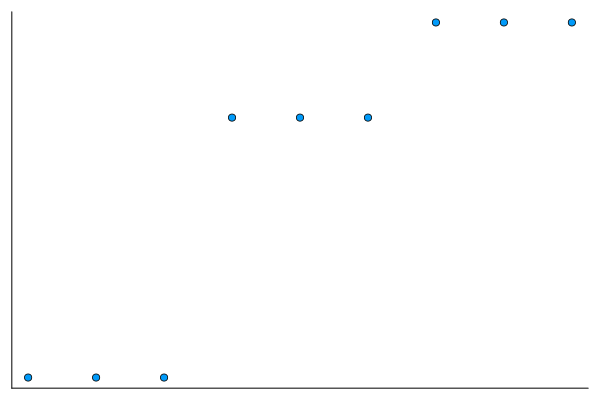

In [123]:
using Plots

# Plots Bands
scatter(1:length(filtered_energies), filtered_energies, legend=false, axis=nothing)

In [159]:
# Eigen-States of Filtered Particle Number 
function Filtered_Hubbard_States(filtered_energies, states)
    number_of_states = length(filtered_energies)
    # i = sortperm(filtered_energies, by=real); filtered_energies = filtered_energies[i]
    # states = states[:,i]
    return states[:,1:number_of_states]
end

Filtered_Hubbard_States (generic function with 1 method)

In [161]:
# # Calculate the Matrix Form to Get Eigenstates as Matrix Form
# function get_Matrix_form(basis_cut_mb, H_total)
#     # Convert the Hamiltonian from Operator to Matrix Form
#     H_Total_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb))
#     for i in 1:length(basis_cut_mb)
#         for j in 1:length(basis_cut_mb)
#             #H_Total_Matrix[i,j] = ((H_total+H_total')/2).data[i,j]
#             H_Total_Matrix[i,j] = H_total.data[i,j]
#         end
#     end
    
#     return H_Total_Matrix
# end

In [179]:
function get_eigenstates(basis_cut_mb, H_total, pn)
    
    # H_total_Matrix = get_Matrix_form(basis_cut_mb, H_total)
    # E = eigvals(H_total_Matrix)
    # V = eigvecs(H_total_Matrix)
    
    E, V = eigen(dense((H_total+H_total')/2).data)
    
    df = get_filtered_energies(pn, basis_cut_mb, H_total)
    filtered_energies = Matrix(df)[:,2]
    filtered_states = Filtered_Hubbard_States(filtered_energies, V)
    
    return filtered_energies, filtered_states
end

# Orthogonality 
filtered_energies, filtered_states = get_eigenstates(basis_cut_mb, H_total, pn)
a = filtered_states[:,1]
b = filtered_states[:,1]
dot(a,b)

0.9999999999999993 + 0.0im

# CHERN CALCULATION SECTION

In [180]:
# Mesh Grid for Theta Space Parameter
dx=2*pi/T_size; dy=dx;
Tx=range(start=0, stop=2*pi-dx, step=dx)
Ty=range(start=0, stop=2*pi-dy, step=dy);

In [181]:
function Chern_Nums(n1, n2)
    
    Sum=0
    
    for tx in range(start=1, stop=length(Tx))
        for ty in range(start=1, stop=length(Ty))
            
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w1, v1 = get_eigenstates(basis_cut_mb, H_Total, pn)
            
            # sorting eigenvalues
            i = sortperm(w1, by=real);w1 = w1[i]
            # sorting eigenstates
            v1 = v1[:,i]
            # multiplet eigenstates
            v1 = v1[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w2, v2 = get_eigenstates(basis_cut_mb, H_Total, pn)
            
            i = sortperm(w2, by=real);w2 = w2[i]
            v2 = v2[:,i]
            v2 = v2[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w3, v3 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            i = sortperm(w3, by=real);w3 = w3[i]
            v3 = v3[:,i]
            v3 = v3[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w4, v4 = get_eigenstates(basis_cut_mb, H_Total, pn)
            
            i = sortperm(w4, by=real);w4 = w4[i]
            v4 = v4[:,i]
            v4 = v4[:,n1:n2]
            
            #----------LINK VARIABLES------------
            U1=det(adjoint(v1)*v2)
            U1=U1/abs(U1)
            U2=det(adjoint(v2)*v4)
            U2=U2/abs(U2)
            U3=det(adjoint(v3)*v4)
            U3=U3/abs(U3)
            U4=det(adjoint(v1)*v3)
            U4=U4/abs(U4)
            
            #----------BERRY CURVATURE-----------
            F=log(U1*U2*1/U3*1/U4)
            Sum=Sum+F
            
        end
    end
    
    return 1/(2*pi*1im)*Sum
end

Chern_Nums (generic function with 2 methods)

In [182]:
Chern_Nums(1, 3)

-0.13988262927506948 + 3.498845257343905e-17im

# Check with "Hofstadter MB Chern" file

In [78]:
pn = 1
tx = ty = 2
#---
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
w1, v1 = get_eigenstates(basis_cut_mb, H_Total, pn)
i = sortperm(w1, by=real);w1 = w1[i]
v1 = v1[:,i] 
#---
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
w2, v2 = get_eigenstates(basis_cut_mb, H_Total, pn)
i = sortperm(w2, by=real);w2 = w2[i]
v2 = v2[:,i]
#---
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)       
w3, v3 = get_eigenstates(basis_cut_mb, H_Total, pn)
i = sortperm(w3, by=real);w3 = w3[i]
v3 = v3[:,i]
#---
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
w4, v4 = get_eigenstates(basis_cut_mb, H_Total, pn)
i = sortperm(w4, by=real);w4 = w4[i]
v4 = v4[:,i]
#---
U1=det(adjoint(v1)*v2)
U1=U1/abs(U1)
println(U1)
U2=det(adjoint(v2)*v4)
U2=U2/abs(U2)
println(U2)
U3=det(adjoint(v3)*v4)
U3=U3/abs(U3)
println(U3)
U4=det(adjoint(v1)*v3)
U4=U4/abs(U4)
println(U4)

NaN + NaN*im
0.7123741056618625 - 0.7017999241824279im
-0.28923609090551833 - 0.9572577937617927im
NaN + NaN*im


In [51]:
Tx[1]

0.0

In [73]:
w1

9-element Vector{Float64}:
 -2.5466393943271597
 -2.546639394327157
 -2.5466393943271535
  0.20750036611082506
  0.20750036611082523
  0.20750036611082567
  2.3391390282163353
  2.3391390282163353
  2.3391390282163362

In [74]:
w2

9-element Vector{Float64}:
 -2.361468766185828
 -2.361468766185824
 -2.361468766185822
 -0.1674491911085357
 -0.1674491911085325
 -0.16744919110852985
  2.528917957294362
  2.5289179572943623
  2.5289179572943628

In [71]:
det(v1'*v2)

0.0 + 0.0im